In [1]:
import os
import json
import logging
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from typing import List, TypedDict
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage,SystemMessage
from langchain_core.documents import Document
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import NotebookLoader, WebBaseLoader
import html2text
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from pydantic import BaseModel

from IPython.display import Image, display


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()
llm = AzureChatOpenAI(azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"])


embeddings = AzureOpenAIEmbeddings(
openai_api_type="azure",
openai_api_version=os.environ["OPENAI_API_EMBEDDING_VERSION"],
openai_api_key=os.environ["OPENAI_API_EMBEDDING_KEY"],
azure_endpoint=os.environ["AZURE_OPENAI_EMBEDDING_ENDPOINT"],
deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"],
model=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
validate_base_url=True,
)

In [3]:

# Set up the logger
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for detailed logs
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        # logging.FileHandler("scraper.log"),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)
logger = logging.getLogger(__name__)


# Vector Store creation

In [4]:
import aiohttp
import asyncio
from bs4 import BeautifulSoup
import json

async def parse_url_to_doc(url: str) -> str:
    try:
        timeout = aiohttp.ClientTimeout(total=10)  # Set timeout to 3 seconds
        async with aiohttp.ClientSession() as session:
            async with session.get(url, timeout= timeout) as response:
                if response.status != 200:
                    logger.warning(f"Failed to fetch {url}: Status code {response.status}")
                    return None
                html_content = await response.text()
                soup = BeautifulSoup(html_content, 'html.parser')
                target_div = soup.find('div', class_= "theme-doc-markdown markdown") #langchain

                if not target_div:
                    target_div = soup.find('article') #langraph

                if not target_div:
                    return None

                return Document(page_content=html2text.html2text(str(target_div)), metadata={"source": url})
    except Exception as e:
        logger.error(f"Error in parsing {url}: {e}")
        


In [5]:
with open('webscraping/visited_urls_langgraph.json', 'r') as f:
    urls = json.load(f)

    # Generator function to yield 10 items at a time
    def batch_iterator(iterable, batch_size):
        for i in range(0, len(iterable), batch_size):
            yield iterable[i:i + batch_size]

    batch_size = 10

    # Create the iterator
    iterator = batch_iterator(urls, batch_size)

    documents = []

    # Use the iterator
    for batch in iterator:
        tasks = [parse_url_to_doc(url) for url in batch]
        results = await asyncio.gather(*tasks)
        documents.append(results)
    documents = [item for sublist in documents for item in sublist]
    documents =  [item for item in documents if item != None]

2025-03-30 17:38:58,745 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/breakpoints: Status code 404
2025-03-30 17:38:58,760 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/command: Status code 404
2025-03-30 17:38:58,890 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/agentic_concepts: Status code 404
2025-03-30 17:38:58,902 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/autogen-integration: Status code 404
2025-03-30 17:38:58,909 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/async: Status code 404
2025-03-30 17:38:58,920 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/autogen-integration-functional: Status code 404
2025-03-30 17:38:59,173 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/branching: Status code 404
2025-03-30 17:39:03,902 - WARNING - Failed to fetch https://langchain-ai.github.io/langgraph/cross-thread-persistence: Status 

In [6]:
documents.__len__()

170

In [ ]:
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=3000, chunk_overlap=300
)
doc_splits = text_splitter.split_documents(documents)

len(doc_splits)

In [14]:
doc_len=0

for doc in documents:
    doc_len += doc.page_content.__len__()
    
print(doc_len)

14891858


In [21]:
doc_len/170

87599.16470588236

In [ ]:
doc_iterator = batch_iterator(urls, 10)


In [ ]:

vector_store = InMemoryVectorStore(embeddings)
ids = vector_store.add_documents(documents=doc_splits)

vec_retriever = vector_store.as_retriever(search_kwargs={'k': 10})
retriever_tool = create_retriever_tool(
    vec_retriever,
    "retrieve_langchain_and_langgraph_information",
    "Search and return information on langchain and langgraph documentation about LLM agents, prompt engineering, Langgraph documentation, and writing python code to build langgraphs.",
)

tools = [retriever_tool]

2025-03-30 16:03:34,994 - INFO - HTTP Request: POST https://kanis-m8htxgs7-eastus.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15 "HTTP/1.1 429 Too Many Requests"
2025-03-30 16:03:35,026 - INFO - Retrying request to /embeddings in 60.000000 seconds
2025-03-30 16:04:57,055 - INFO - HTTP Request: POST https://kanis-m8htxgs7-eastus.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15 "HTTP/1.1 429 Too Many Requests"
2025-03-30 16:04:57,068 - INFO - Retrying request to /embeddings in 60.000000 seconds
2025-03-30 16:06:17,598 - INFO - HTTP Request: POST https://kanis-m8htxgs7-eastus.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15 "HTTP/1.1 429 Too Many Requests"


RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the Embeddings_Create Operation under Azure OpenAI API version 2023-05-15 have exceeded call rate limit of your current AIServices S0 pricing tier. Please retry after 60 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit. For Free Account customers, upgrade to Pay as you Go here: https://aka.ms/429TrialUpgrade.'}}

In [15]:
# Input list of URLs
url_list = ["example.com", "example.com/", "example.com/test", "example.com/test/", "another.com"]

# Normalize and remove duplicates
unique_urls = list(set(url.rstrip('/') for url in url_list))

# Output the result
print(unique_urls)
# Example output: ['example.com/test', 'example.com', 'another.com']

['example.com', 'another.com', 'example.com/test']


In [14]:
vector_store.similarity_search("what is langgraph")

2025-03-30 16:08:02,859 - INFO - HTTP Request: POST https://kanis-m8htxgs7-eastus.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15 "HTTP/1.1 200 OK"


[]

# Agent definition

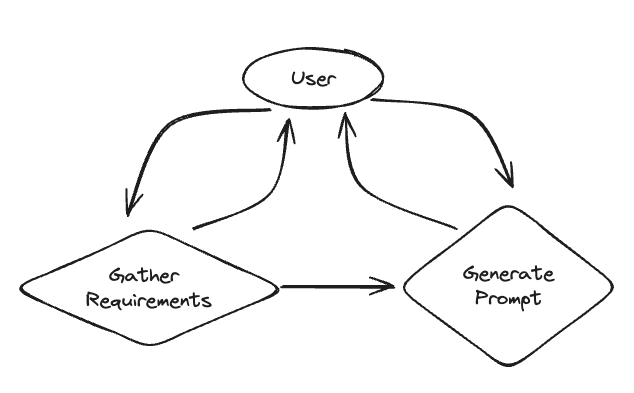

In [ ]:
# TODO first subagent to create from https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

# TODO critical thinking to allow for model suggestions

from pydantic import Field


template = """Your job is to get information from a user about what kind of agent they wish to build.

You should get the following information from them:

- What the objective of the agent is
- Various responsibilities of the agent 
- What model provider to use

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""

def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class AgentInstructions(BaseModel):
    """Instructions on how to build the Agent"""
    objective: str = Field(description= "What is the primary objective of the agent")
    responsibilities: List[str] = Field(description= "What are the various responsibilities of the agent which it needs to fulfill")
    model_provider : str = Field(description= "Which model provider powers the LLM workload? eg. OpenAI/Claude/CodeLLama etc.")


llm_with_tool = llm.bind_tools([AgentInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}


# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}




def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"



class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
infograph = workflow.compile(checkpointer=memory)

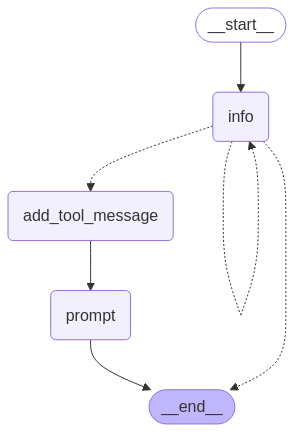

In [20]:
display(Image(infograph.get_graph().draw_mermaid_png()))


In [25]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in infograph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): I wish to build an agent with the primary purpose of investigating production issues
================================== Ai Message ==================================

Great! Investigating production issues is an important task. 

Could you please provide more details on the following:

1. What specific responsibilities do you want this agent to handle? For example, should it analyze logs, monitor performance, notify the team, etc.?
   
2. Which model provider do you want to use for powering the LLM workload (e.g., OpenAI, Claude, CodeLLama, etc.)?
User (q/Q to quit): It should analyze the logs based on past documented incidents, monitor performance and generate alerts, notify team, also perform mitigation steps when necessary
================================== Ai Message ==================================

Thank you for the details on the responsibilities. 

Now, could you please specify which model provider you would like to use for this agent (e.g., OpenAI, Claude

# HLD subagent

In [ ]:


def retriever(state : MessagesState):
    """Retrieve relevant information based on the last message in the message history.

    Args:
        state (MessagesState): state to be updated
    """
    relevant_docs : list[Document] = vec_retriever.invoke(state.messages[-1])
    
    

    

# Edge Conditional Edge Definitions

In [ ]:
def should_continue():
    return "agent"

# Compilation

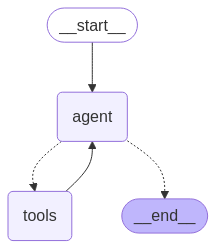

In [ ]:

def call_model(state: MessagesState):
    return state


tool_node = ToolNode([])

workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))